In [ ]:
# Install the necessary packages
!pip install gymnasium pyvirtualdisplay > /dev/null 2>&1
!pip install pygame

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pygame

In [ ]:
# Create the grid environment
class FrozenLake(gym.Env):
  def __init__(self, grid_width, grid_height, grid_description):
      self.width = grid_width
      self.height = grid_height
      self.observation_space = spaces.Discrete(grid_width*grid_height)
      self.action_space = spaces.Discrete(4)
      self.location = (0,0)
      self.grid = np.array(list(grid_description)).reshape((grid_height, grid_width))

In [ ]:
# Define an observation
class FrozenLake(FrozenLake):
  def _get_obs(self):
      return self.location

In [ ]:
# Reset the environment
class FrozenLake(FrozenLake):
  def reset(self, seed=None, options=None):
    super().reset(seed=seed)
    self.location = (0,0)
    observation = self._get_obs()
    info = None
    return observation, info

In [ ]:
# Compute reward for the agent at any given state
class FrozenLake(FrozenLake):
  def compute_reward(self, observation):
      if (observation[0] < 0 or observation[0] >= self.width or observation[1] < 0 or observation[1] >= self.height):
        reward = -100
      else:
        grid_state = self.grid[observation[1]][observation[0]]
        if grid_state == "G":
          reward = 100
        elif grid_state == "I":
          reward = -2
        elif grid_state == "H":
          reward = -50
      return reward

In [ ]:
# Define the movement function for the agent
from typing_extensions import Self
class FrozenLake(FrozenLake):
  def step(self, action):
      if action == 0: #North
        self.location = (self.location[0], self.location[1]-1)
      elif action == 1: #East
        self.location = (self.location[0]+1, self.location[1])
      elif action == 2: #South
        self.location = (self.location[0], self.location[1]+1)
      elif action == 3: #West
        self.location = (self.location[0]-1, self.location[1])
      # The above implementation allows the agent to go out of bounds, at which
      # point it would terminate fully
      observation = self._get_obs()
      reward = self.compute_reward(observation)

      if reward == 100 or reward == -100 or reward == -50:
        terminated = True
      else:
        terminated = False

      return observation, reward, terminated, False, None

In [ ]:
# Render the lake using PyGame
class FrozenLake(FrozenLake):
  def _render_frame(self, screen, window_width, window_height):
    rect_width = window_width/self.width
    rect_height = window_height/self.height
    agent_x_location = (self.location[0]+0.5)*rect_width
    agent_y_location = (self.location[1]+0.5)*rect_height
    for i in range (0, self.height):
      for j in range (0, self.width):
        if self.grid[i][j] == "I":
          color = (255, 255, 255)
        elif self.grid[i][j] == "H":
          color = (0, 0, 0)
        elif self.grid[i][j] == "G":
          color = (0, 255, 0)
        pygame.draw.rect(screen, color, (j*rect_width, i*rect_height, rect_width, rect_height))
    pygame.draw.circle(screen, "purple",(agent_x_location, agent_y_location), min(rect_width, rect_height) * 1 /3)
  def render(self, screen, window_width, window_height):
    return self._render_frame(screen, window_width, window_height)

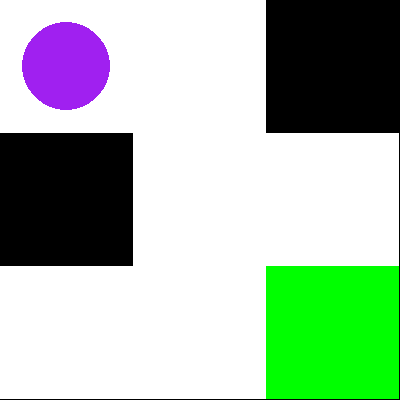

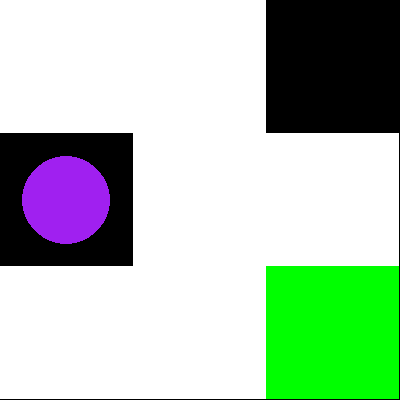

In [ ]:
# Check that agent is capable of moving randomly
import cv2
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import time

lake = FrozenLake(3, 3, "IIHHIIIIG")
window_width = 400
window_height = 400
pygame.init()
screen = pygame.display.set_mode((window_width, window_height))

for i in range(0, 1):
  observation, info = lake.reset()
  terminated = False
  lake.render(screen, window_width, window_height)
  view = pygame.surfarray.array3d(screen)
  view = view.transpose([1, 0, 2])
  img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  cv2_imshow(img_bgr)
  time.sleep(.5)
  while not terminated:
    action = lake.action_space.sample()
    observation, reward, terminated, truncated, info = lake.step(action)
    # If the agent went out of bounds it disappears from the displayed grid and
    # only the blank grid is shown
    lake.render(screen, window_width, window_height)
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)
    time.sleep(.5)

In [ ]:
# Make a class to perform q-learning (reinforcement learning) and define the
# table of updates
import random

class QLearning():
  def __init__(self, env, exploration, gamma, alpha, obs_space_n, action_space_n):
    self.env = env
    self.exploration = exploration
    self.gamma = gamma
    self.alpha = alpha

    qtable = {}
    for i in range (0, env.width):
      for j in range (0, env.height):
        q_actions = {}
        qtable[(i,j)] = q_actions
        for k in range (0, action_space_n):
          q_actions[k] = 0
    self.q_table = qtable

In [ ]:
# Define a sample action to take during the process of training
class QLearning(QLearning):
  def sample_action(self, observation):
    random_number = random.random()
    if random_number < self.exploration:
      return self.env.action_space.sample()
    else:
      actions = self.q_table[observation]
      optimalaction = max(actions, key=actions.get)
      return optimalaction

In [ ]:
# Method that updates the table
class QLearning(QLearning):
  def update_table(self, observation, action, reward, new_observation, terminated):
      if terminated:
        self.q_table[observation][action] = reward
      else:
        actions = self.q_table[new_observation]
        max_reward = max(actions.values())
        sample = (reward + self.gamma*max_reward)
        self.q_table[observation][action] = (1-self.alpha)*self.q_table[observation][action] + self.alpha*sample

Use the two classes defined below to train your policy so that it solves the environment.

In [ ]:
# Train the q-learning policy so agent learns optimal path to goal
lake = FrozenLake(5, 5, "IIIHIHIHHHIIIIGIIIIHIIIIH")
q_learning = QLearning(lake, .3, .99, .9, lake.width * lake.height, lake.action_space.n)
for i in range (0, 10000):
  observation, info = lake.reset()
  terminated = False
  while (not terminated):
    action = q_learning.sample_action(observation)
    new_observation, reward, terminated, truncated, info = lake.step(action)
    q_learning.update_table(observation, action, reward, new_observation, terminated)
    observation = new_observation

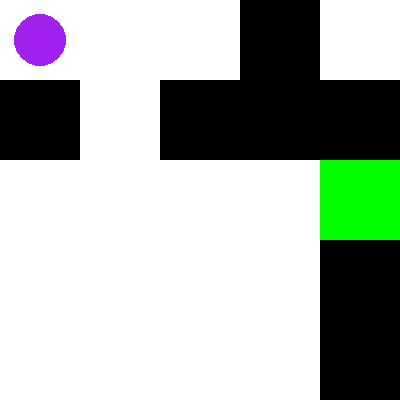

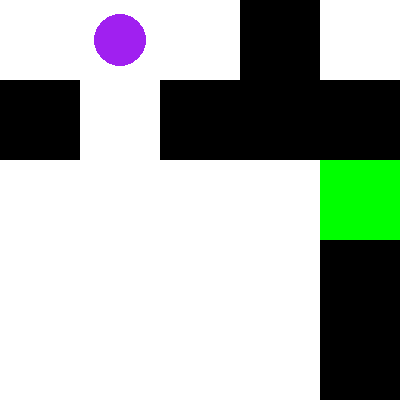

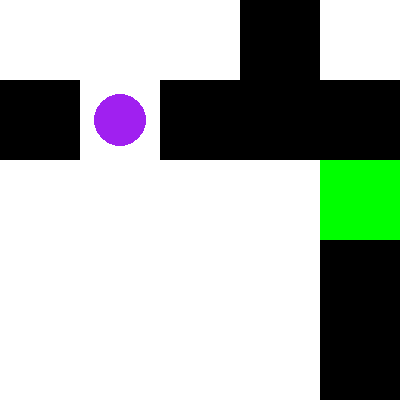

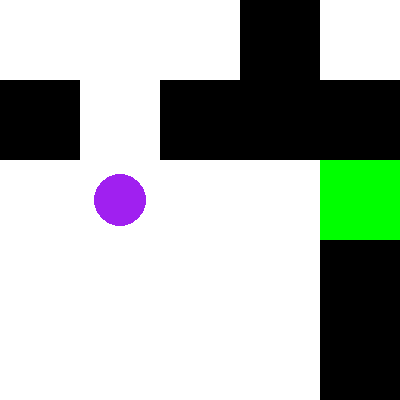

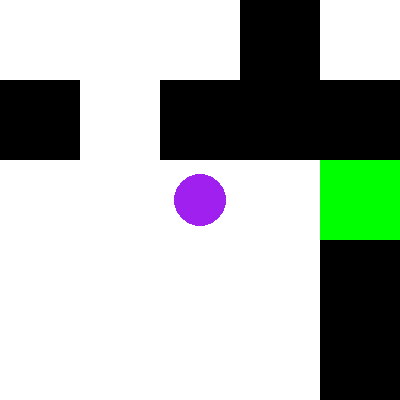

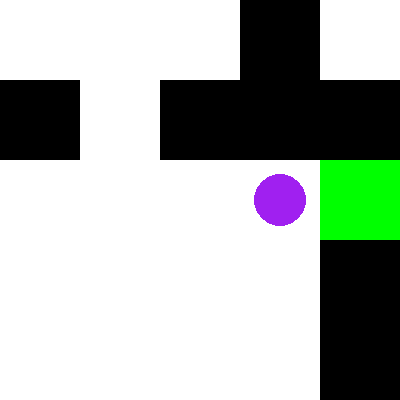

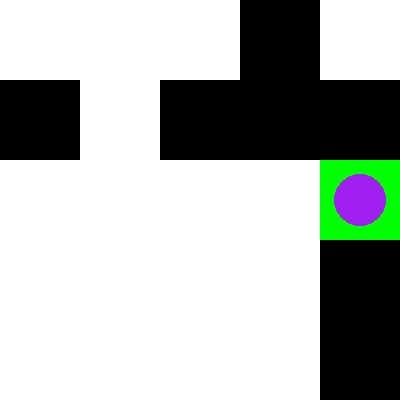

In [ ]:
# Run the solved problem!
q_learning.exploration = 0.0
for i in range(0, 1):
  observation, info = lake.reset()
  terminated = False
  lake.render(screen, window_width, window_height)
  view = pygame.surfarray.array3d(screen)
  view = view.transpose([1, 0, 2])
  img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
  cv2_imshow(img_bgr)
  time.sleep(.5)
  # Removed the clear_output line so that we show initial output.
  while not terminated:
    action = q_learning.sample_action(observation)
    observation, reward, terminated, truncated, info = lake.step(action)
    lake.render(screen, window_width, window_height)
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)
    time.sleep(.5)